<a href="https://colab.research.google.com/github/kulc7878/colab/blob/master/(4W)_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/

!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
 10m_sample.ipynb
'(3W) tag_data_anomaly_detection.ipynb'
'(3W) tag_data_anomaly_detection.ipynb의 사본-1'
'(3W) tag_data_anomaly_detection.ipynb의 사본-2'
'(3W) yahoo_sub5.ipynb'
'(4W-2) LSTM_AutoEncoder.ipynb'
'(4W-3) LSTM_AutoEncoder.ipynb'
'(4W) LSTM_AutoEncoder.ipynb'
'(4W-Total) LSTM_AutoEncoder.ipynb'
 DBScan.ipynb
 Def_DataRefine_All.ipynb
 Def_DataRefine.ipynb
 데이터전처리.ipynb
 LSTM-AutoEncoding.ipynb
 LSTM.ipynb
 Sample_DataRefine.ipynb
 test_AD.ipynb
 test-Interpolation.ipynb
'timeseries_anomaly_detection - Keras.io'


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Abnormal"]

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Loading the data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/colab_data/http_csv.csv")

# Exploration

In [ ]:
print(df.shape)
print(df)

(567498, 5)
        time_stamp   value_1   value_2    value_3  abnomal
0                1 -2.302585  5.371103  10.716107        0
1                2 -2.302585  5.088213   8.418058        0
2                3 -2.302585  5.464255   7.113224        0
3                4 -2.302585  5.451468   7.616825        0
4                5 -2.302585  5.476882   6.186414        0
...            ...       ...       ...        ...      ...
567493      567494 -2.302585  5.357058   7.735477        0
567494      567495 -2.302585  5.389528   5.464255        0
567495      567496 -2.302585  5.384954   8.191491        0
567496      567497 -2.302585  5.389528   7.118097        0
567497      567498 -2.302585  5.389528   7.001337        0

[567498 rows x 5 columns]


In [ ]:
df.isnull().values.any()  #결측값(missing value)이 있는지 확인

False

In [ ]:
normal = df[df.abnomal == 0]
abnormal = df[df.abnomal == 1]

print(normal.shape, ',', abnormal.shape)

(565287, 5) , (2211, 5)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

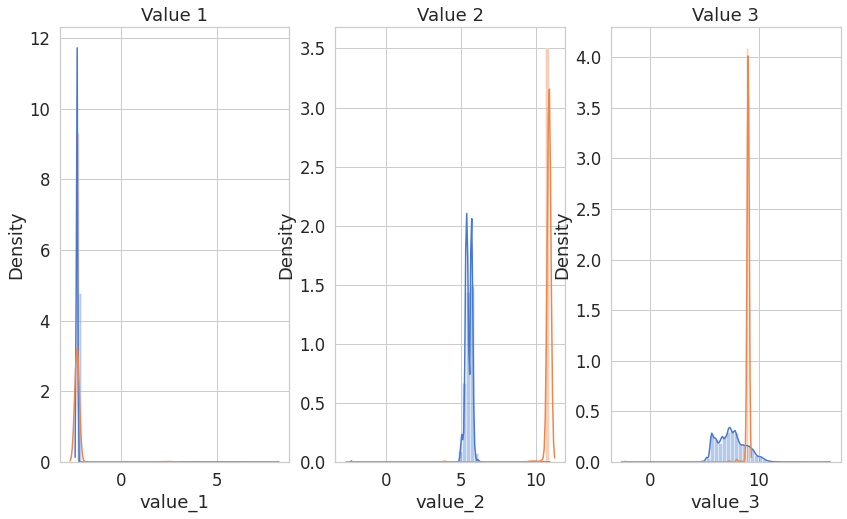

In [ ]:
import seaborn as sns
import matplotlib.gridspec as gridspec

f,ax=plt.subplots(1, 3)

sns.distplot(df[df.abnomal == 0].value_1,ax=ax[0])
sns.distplot(df[df.abnomal == 1].value_1,ax=ax[0])
ax[0].set_title('Value 1')

sns.distplot(df[df.abnomal == 0].value_2,ax=ax[1])
sns.distplot(df[df.abnomal == 1].value_2,ax=ax[1])
ax[1].set_title('Value 2')

sns.distplot(df[df.abnomal == 0].value_3,ax=ax[2])
sns.distplot(df[df.abnomal == 1].value_3,ax=ax[2])
ax[2].set_title('Value 3')

plt.show()

In [ ]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=False)
f.suptitle('Time vs Value_1~3 by class')

ax1.scatter(abnormal.time_stamp, abnormal.value_1)
ax1.set_title('Abnormal-1')

ax2.scatter(abnormal.time_stamp, abnormal.value_2)
ax2.set_title('Abnormal-2')

ax3.scatter(abnormal.time_stamp, abnormal.value_3)
ax3.set_title('Abnormal-3')

ax4.scatter(normal.time_stamp, normal.value_1)
ax4.set_title('Normal-1')

ax5.scatter(normal.time_stamp, normal.value_2)
ax5.set_title('Normal-2')

ax6.scatter(normal.time_stamp, normal.value_3)
ax6.set_title('Normal-3')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Value_1~3')
plt.show()

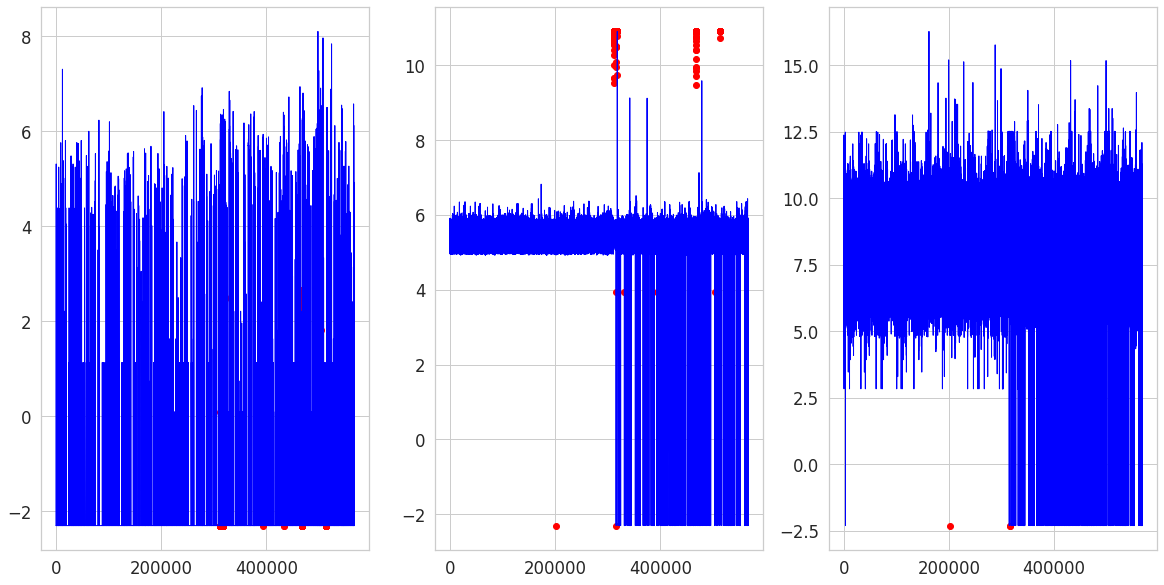

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

ax1.plot(normal.value_1, label='Value_1', color='blue', animated = True, linewidth=1)
ax1.scatter(abnormal.value_1.index
           , abnormal.value_1
           , label='anomal', marker='o', color='red')

ax2.plot(normal.value_2, label='Value_2', color='blue', animated = True, linewidth=1)
ax2.scatter(abnormal.value_2.index
           , abnormal.value_2
           , label='anomal', marker='o', color='red', )

ax3.plot(normal.value_3, label='Value_3', color='blue', animated = True, linewidth=1)
ax3.scatter(abnormal.value_3.index
           , abnormal.value_3
           , label='anomal', marker='o', color='red')

plt.show()

# Preparing the data

StandardScaler<br/><b/>
(x - x의 평균값) / x의 표준편차

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['time_stamp'], axis=1)

data['value_1'] = StandardScaler().fit_transform(data['value_1'].values.reshape(-1, 1))
data['value_2'] = StandardScaler().fit_transform(data['value_2'].values.reshape(-1, 1))
data['value_3'] = StandardScaler().fit_transform(data['value_3'].values.reshape(-1, 1))

data

,value_1,value_2,value_3,abnomal
0,-0.073165,-0.428904,2.450210,0
1,-0.073165,-1.079216,0.705273,0
2,-0.073165,-0.214764,-0.285503,0
3,-0.073165,-0.244161,0.096888,0
4,-0.073165,-0.185738,-0.989240,0
...,...,...,...,...
567493,-0.073165,-0.461192,0.186982,0
567494,-0.073165,-0.386548,-1.537584,0
567495,-0.073165,-0.397064,0.533238,0
567496,-0.073165,-0.386548,-0.281802,0


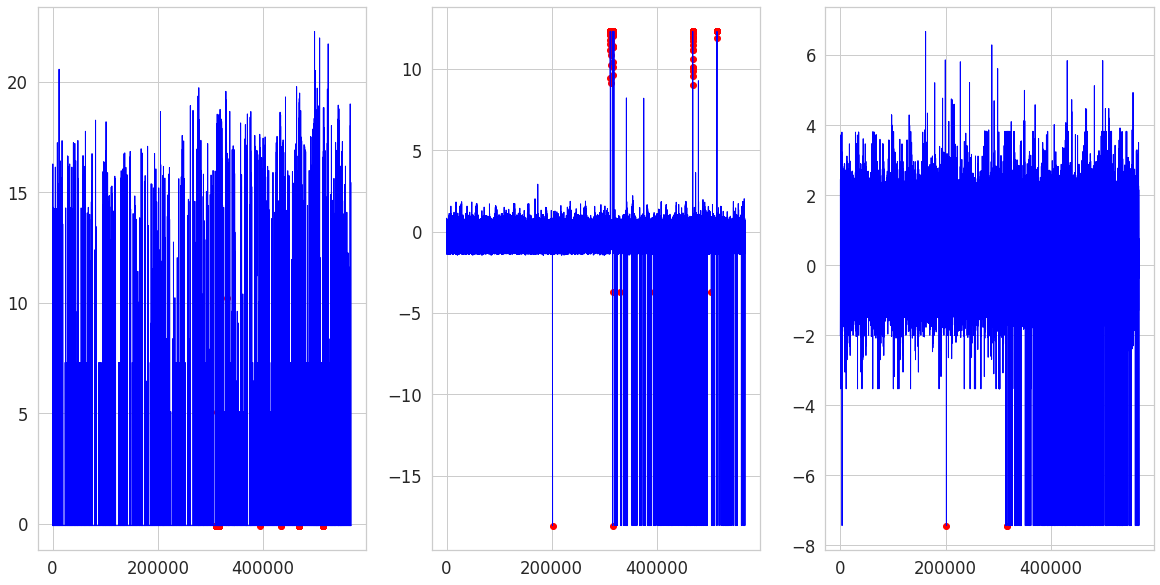

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

ax1.plot(data.value_1, label='Value_1', color='blue', animated = True, linewidth=1)
ax1.scatter(data[data.abnomal == 1].index
           , data[data.abnomal == 1].value_1
           , label='anomal', marker='o', color='red')

ax2.plot(data.value_2, label='Value_2', color='blue', animated = True, linewidth=1)
ax2.scatter(data[data.abnomal == 1].index
           , data[data.abnomal == 1].value_2
           , label='anomal', marker='o', color='red', )

ax3.plot(data.value_3, label='Value_3', color='blue', animated = True, linewidth=1)
ax3.scatter(data[data.abnomal == 1].index
           , data[data.abnomal == 1].value_3
           , label='anomal', marker='o', color='red')

plt.show()

정상 기록으로만 훈련.

정상의 20%를 테스트로 사용.

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
# nomal 데이터만
X_train = X_train[X_train.abnomal == 0]
# abnomal col 삭제
X_train = X_train.drop(['abnomal'], axis=1)

#y_test abnomal 0,1 값 셋팅
y_test = X_test['abnomal']
# abnomal col 삭제
X_test = X_test.drop(['abnomal'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [ ]:
print(X_train.shape)  # 567498 * 0.8 - (anomal cnt) = 452232
print(X_test.shape)   # 567498 * 0.2 = 113499.6
print(y_test.shape)   # 567498 * 0.2 = 113499.6

(452232, 3)
(113500, 3)
(113500,)
3547/3547 [==============================] - 4s 1ms/step - loss: 0.6464 - accuracy: 0.2793


[0.6464257836341858, 0.2793391942977905]

# Building the model

4개의 fully connected layer

각 layer는 14, 7, 7, 3개의 뉴런으로 구성

처음 두 개의 layer들은 encoder, 뒤의 두 개는 decoder

과대/과소 적합을 피하기 위한 L1 정규화(regularization) 사용, (L2 도 존재)

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [ ]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Autoencoder 모델의 파라미터(parameter)들을 학습 오류가 최소화되도록 최적화시킵니다. 이 때 쓰이는 학습 오류는 재구성 오류(reconstruction error) 입니다. <br/>
일반적인 MSE 사용

In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/colab_data/model-4w-0.0001.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/colab_data/logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1
                    ,callbacks=[checkpointer, tensorboard, earlyStopping]
                    ).history

Epoch 1/100
14133/14133 [==============================] - 23s 2ms/step - loss: 0.5150 - accuracy: 0.6312 - val_loss: 0.3530 - val_accuracy: 0.9714
Epoch 2/100
14133/14133 [==============================] - 22s 2ms/step - loss: 0.2605 - accuracy: 0.9729 - val_loss: 0.3137 - val_accuracy: 0.9698
Epoch 3/100
14133/14133 [==============================] - 22s 2ms/step - loss: 0.2576 - accuracy: 0.9705 - val_loss: 0.2983 - val_accuracy: 0.9711
Epoch 4/100
14133/14133 [==============================] - 22s 2ms/step - loss: 0.2596 - accuracy: 0.9704 - val_loss: 0.2959 - val_accuracy: 0.9699
Epoch 5/100
14133/14133 [==============================] - 22s 2ms/step - loss: 0.2560 - accuracy: 0.9691 - val_loss: 0.2958 - val_accuracy: 0.9687
Epoch 6/100
14133/14133 [==============================] - 22s 2ms/step - loss: 0.2737 - accuracy: 0.9691 - val_loss: 0.2882 - val_accuracy: 0.9699
Epoch 7/100
14133/14133 [==============================] - 22s 2ms/step - loss: 0.2609 - accuracy: 0.9689 - val_

In [ ]:
autoencoder = load_model('/content/drive/MyDrive/colab_data/model-4w-0.0001.h5')

# Evaluation

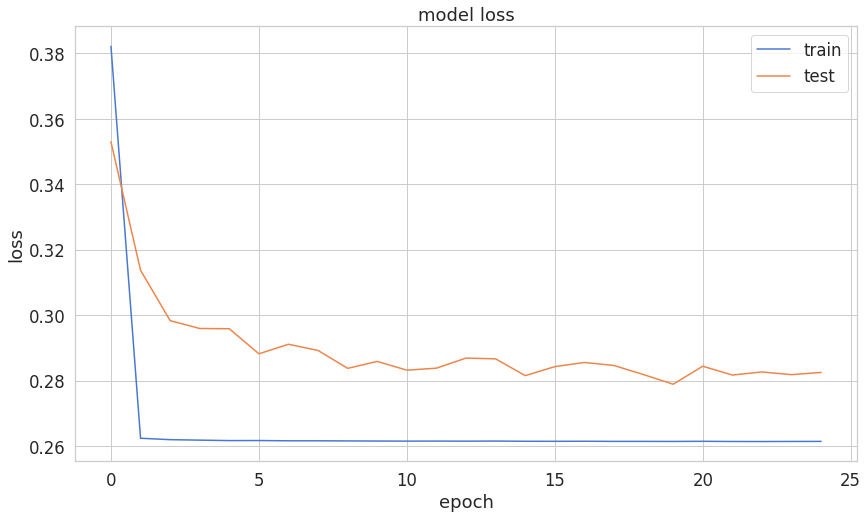

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

# plt.plot(history['accuracy'])
# plt.plot(history['val_accuracy'])
# plt.title('Accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['accuracy', 'val_accuracy'], loc='upper right');

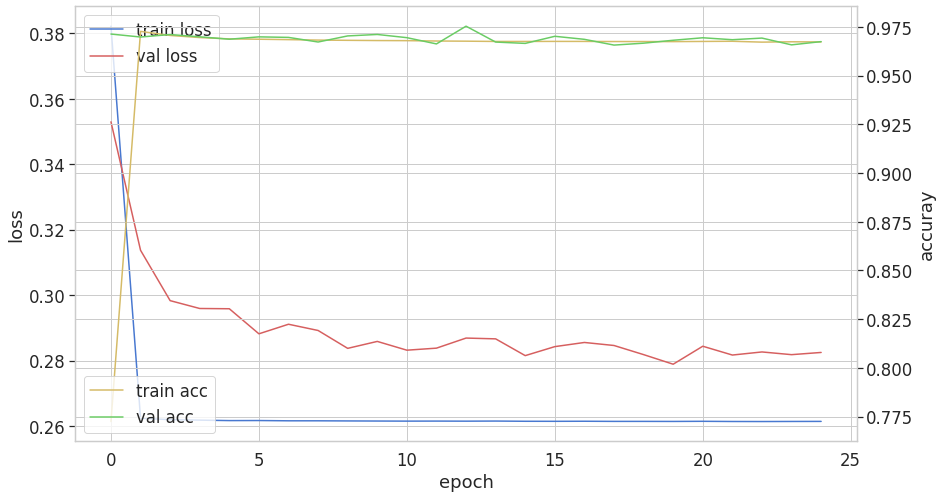

In [ ]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history['loss'], 'b', label='train loss')
loss_ax.plot(history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax = loss_ax.twinx()
acc_ax.plot(history['accuracy'], 'y', label='train acc')
acc_ax.plot(history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

트레이닝 데이터와 테스트 데이터에 대한 재구성 오류가 비슷하게 수렴하고 있는 것처럼 보입니다.

In [ ]:
plt.clf()
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, (len(history['accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

재구성 오류 loss 함수 MSE<br/>
.mse = (입력 값 - 예측값) 의 제곱 - 평균값<br/>
.threshold = (precision, recall 의 접점)<br/>
.abnormal = threshold > mse[...]



In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

# y_test 총 113500, 445건 anomal, 113055 nomal
error_df.describe()

,reconstruction_error,true_class
count,113500.000000,113500.000000
mean,0.282348,0.003921
std,3.134249,0.062493
min,0.000663,0.000000
25%,0.005179,0.000000
50%,0.072139,0.000000
75%,0.299613,0.000000
max,127.365378,1.000000


## 정상 데이터들의 재구성 오류 분포

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## 이상 데이터들의 재구성 오류 분포


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

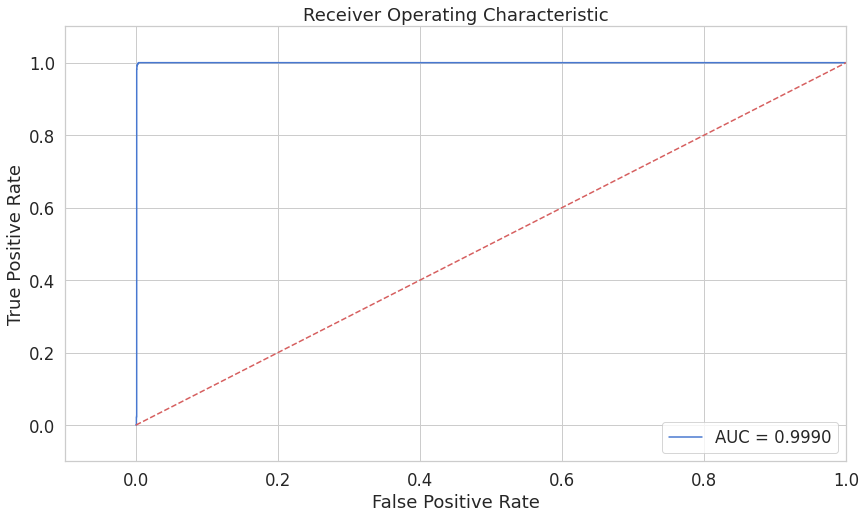

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.001, 1])
# plt.ylim([0, 1.001])
plt.xlim([-0.1, 1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

ROC 곡선은 각 기준치(threshold)가 달라질 때마다 '틀린 것을 맞다고 할 확률'(false positive rate)에 따른 '맞는 것을 맞다고 한 확률'(true positive rate)을 그래프로 그린 것입니다. 기본적으로, 파란색 곡선이 왼쪽 위 모퉁이에 가까워질수록 좋습니다.

## Precision vs Recall

재현율 높다, 정밀도 낮다 => 찾은 데이터의 수가 많지만 그 중 실제 찾으려는 대상의 비율은 낮다

재현율 낮다, 정밀도 높다 => 찾은 데이터의 수는 작지만 그 중 실제 찾으려는 대상의 비율은 높다

이상적으로는, 정밀도와 재현율이 모두 높은 것 좋다.
이는 찾은 데이터 수가 많으며 그 중 실제 찾으려는 대상의 비율이 높다는 것을 의미합니다.

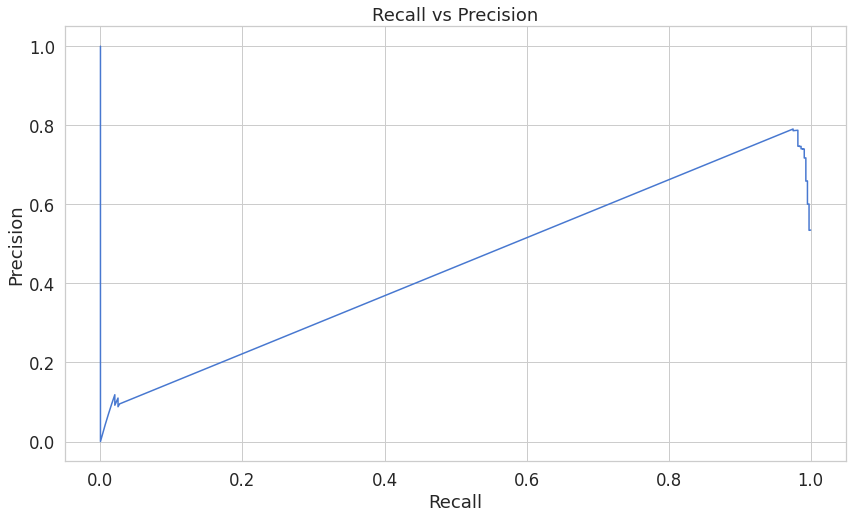

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


곡선 아래 영역 중 위쪽 부분은 높은 재현율과 높은 정밀도를 나타냅니다. 

정밀도 높다 => 거짓인데 참이라고 예측한 것들의 비율이 낮은 것

재현율 높다 => 참인데 거짓이라고 예측한 것들의 비율이 낮은 것

정밀도, 재현률 높다 => 해당 분류기가 실제 참인 데이터들 중 대부분을 찾아낼(높은 재현율)뿐만 아니라, 정확한 결과(높은 정밀도)를 가진다는 것을 의미

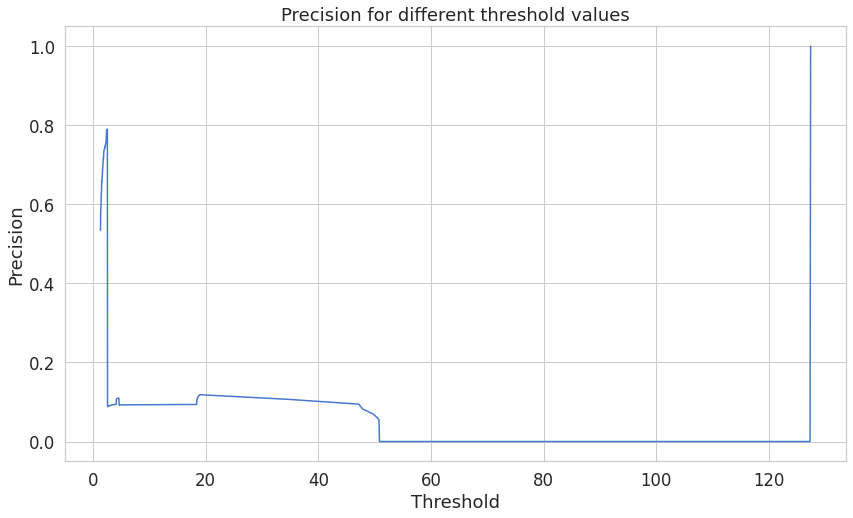

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

재구성 오류가 증가할수록 정밀도가 올라간다는 것을 확인

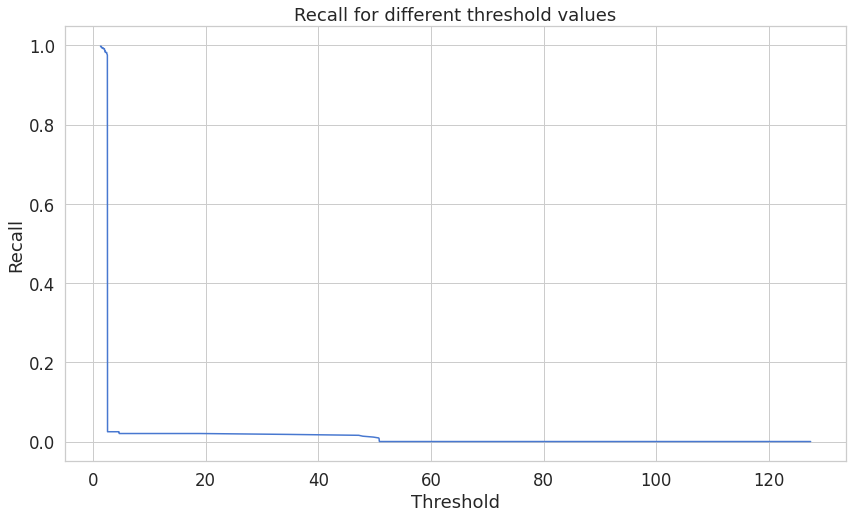

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

재구성 오류가 증가할수록 재현율은 낮아집니다.

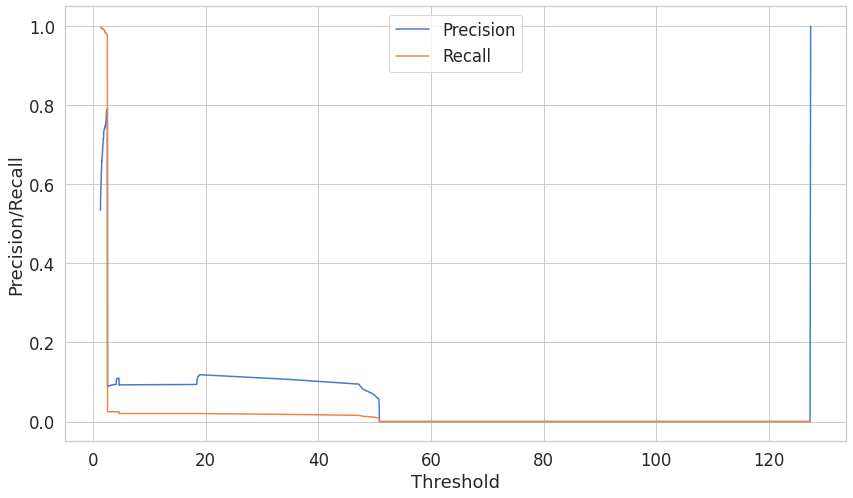

In [ ]:
plt.figure()
plt.plot(th, precision[1:], label='Precision')
plt.plot(th, recall[1:], label='Recall')
plt.xlabel('Threshold');
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [ ]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision, recall)) if p==r][0]
print('index_cnt: ', index_cnt, ', precision: ',precision[index_cnt],', recall: ',recall[index_cnt], )

# fixed Threshold
threshold_fixed = th[index_cnt]
print('threshold: ',threshold_fixed)

index_cnt:  252 , precision:  0.0 , recall:  0.0
threshold:  108.87602776308302


In [ ]:
# threshold = 2.9
# threshold = 128.21529443220243
# threshold = 0.565609038372232
# threshold = 3.128278387824951
# threshold = 1.4
# threshold = 0.64
threshold = 108.87602776308302

And see how well we're dividing the two types of transactions:

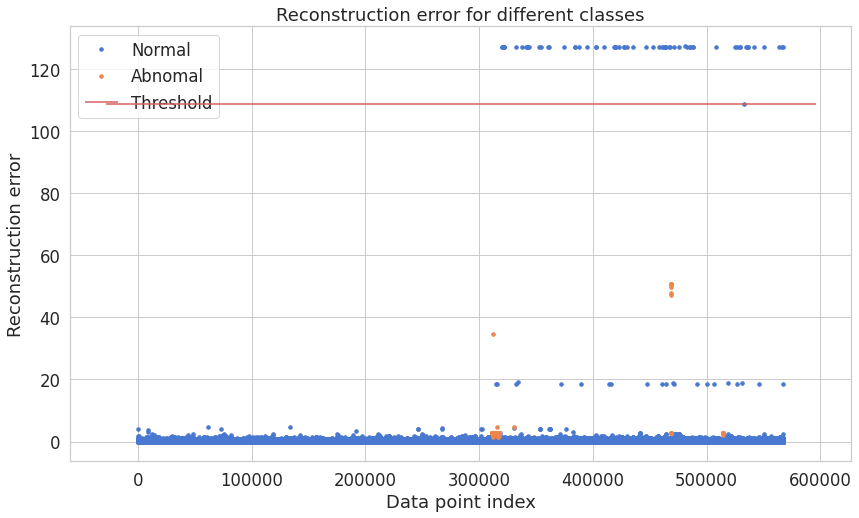

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnomal" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

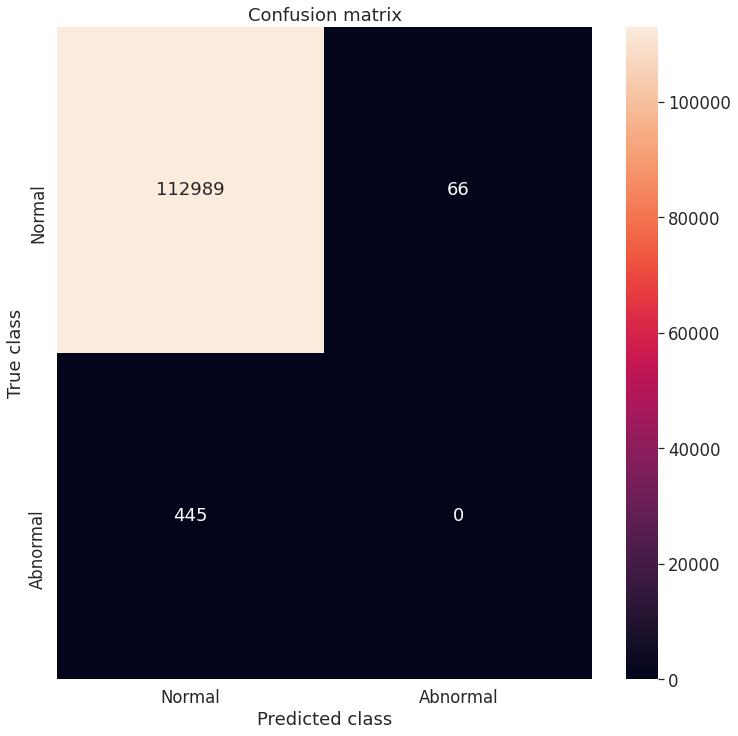

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
tp = conf_matrix[0,0]
fp = conf_matrix[0,1]
fn = conf_matrix[1,0]
tn = conf_matrix[1,1]

total = conf_matrix.sum()
tot_precision = conf_matrix.sum(axis=1)[0]
tot_recall = conf_matrix.sum(axis=0)[0]

print("Accuracy : ", round((tp + tn) / total, 4))
print("Precision : ", round(tp / tot_precision, 4))
print("Recall : ", round(tp / tot_recall, 4))

Accuracy :  0.9955
Precision :  0.9994
Recall :  0.9961


# Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

# References

- [Keras의 Autoencoder를 활용해 신용카드 이상 거래 탐지하기](https://github.com/KerasKorea/KEKOxTutorial/blob/master/20_Keras%EC%9D%98%20Autoencoder%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%B4%20%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EC%9D%B4%EC%83%81%20%EA%B1%B0%EB%9E%98%20%ED%83%90%EC%A7%80%ED%95%98%EA%B8%B0.md#%EC%9D%B4%EC%83%81-%EA%B1%B0%EB%9E%98-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%93%A4%EC%9D%98-%EC%9E%AC%EA%B5%AC%EC%84%B1-%EC%98%A4%EB%A5%98-%EB%B6%84%ED%8F%AC)